In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from scipy import stats
import matplotlib.pyplot as plt
import tropycal
from tropycal import tracks
from shapely.geometry import Polygon, Point


In [2]:
test = np.load('/user/home/al18709/work/ke_track_rain/hr/miroc6_hist_pred.npy')

In [3]:
print(test.shape)

(320671, 100, 100, 1)


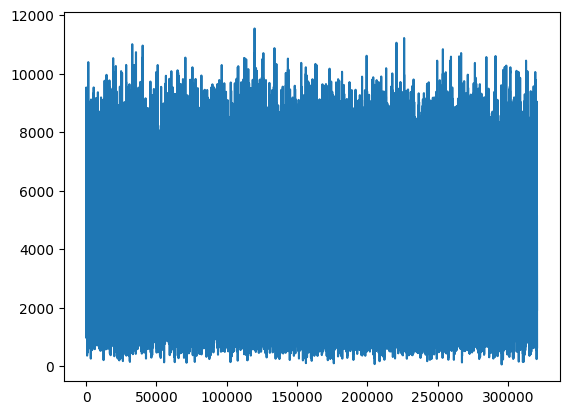

In [4]:
plt.plot(np.sum(test,axis=(1,2,3)))

In [5]:
# Function to check if a point is within the polygon
def is_point_within_polygon(point, polygon):
    return polygon.contains(point)

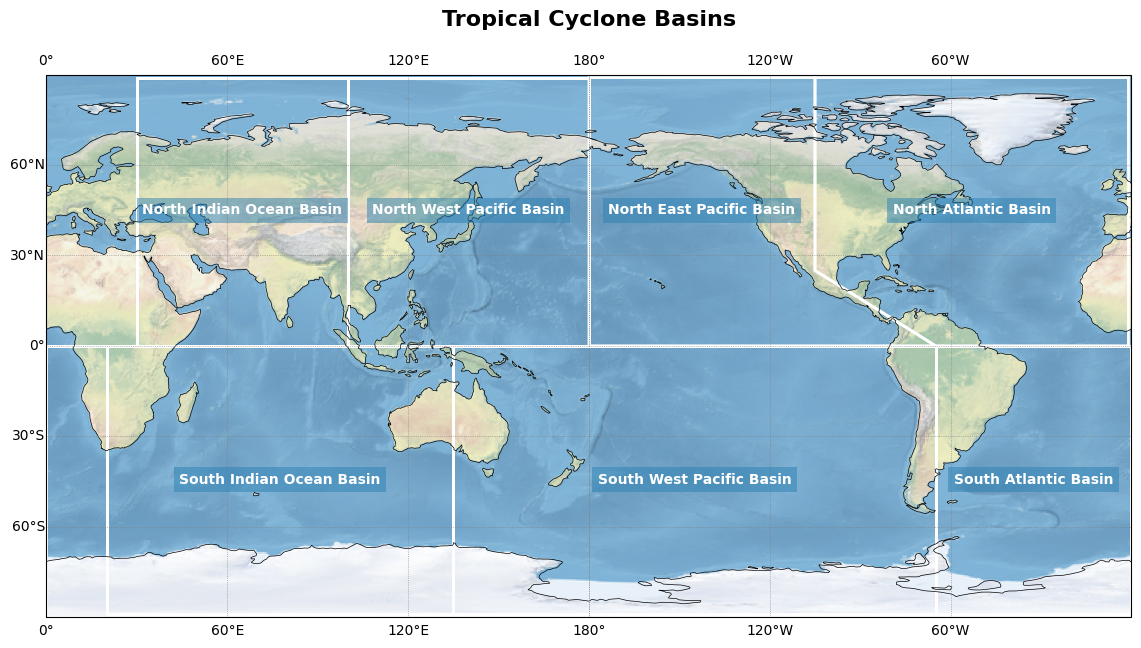

In [6]:
# Create a new figure
plt.figure(figsize=(14, 8))

# Define the projection (PlateCarree for a simple cylindrical projection)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  # Centered on the Pacific Ocean

# Add land and ocean color with elevation
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=cfeature.COLORS['land']))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='none', facecolor=cfeature.COLORS['water']))

# Add coastlines with thinner lines
ax.stock_img()
ax.coastlines(resolution='110m', linewidth=0.5)

# Add grid lines with dotted linestyle
gl = ax.gridlines(draw_labels=True, linestyle=':',color='Gray',linewidth=0.5)

# Label x and y axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set title
ax.set_title('Tropical Cyclone Basins', loc='center',pad=20,weight='bold',fontsize=16)

# Add boxes and text annotations for the tropical cyclone basins
basins = {
    # 'North Atlantic Basin': (85, 179, 0, 90),
    'North Atlantic Basin': [ (75, 25), (75, 89),(85, 89), (179, 89), (179, 0), (115, 0)],
    'North Indian Ocean Basin': (-150, -80, 0, 89),
    # 'North East Pacific Basin': (0, 85, 0,90),
    'North West Pacific Basin': (-80, 0, 0, 89),
    'North East Pacific Basin': [(0,0),(0,89),(75,89),(75,25),(115,0)],
    'South Indian Ocean Basin': (-160, -45, -89, 0),
    # # 'Australian Region': (100, 180, -50, -10),
    'South West Pacific Basin': (-45, 115, -89, 0),
    'South Atlantic Basin': (115, 180, -89, 0),
    '': (-180, -160, -90, 0),
}


# for basin, coords in basins.items():
#     if isinstance(coords, list):
#             basin_patch = plt.Polygon(coords, edgecolor='red', facecolor='none', linewidth=2)
#     else:
#         basin_patch = plt.Rectangle((coords[0], coords[2]), coords[1] - coords[0], coords[3] - coords[2],
#                                         edgecolor='red', facecolor='none', linewidth=2)
#     ax.add_patch(basin_patch)
    
for basin, bbox in basins.items():
    if isinstance(bbox, list):
        basin_patch = plt.Polygon(bbox, edgecolor='white', facecolor='none', linewidth=2)
    else:
        # basin_patch = plt.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
        #                         edgecolor='white', facecolor='none', linewidth=2)
        basin_patch = plt.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
                                        edgecolor='white', facecolor='none', linewidth=2)
        ax.add_patch(basin_patch)
    ax.add_patch(basin_patch)

    if isinstance(bbox, list):
        text_x = (bbox[0][0] + bbox[3][0]) / 2  # Calculate x-coordinate for text
        text_y = 45  # Calculate y-coordinate for text
    else:
        text_x = (bbox[0] + bbox[1]) / 2  # Calculate x-coordinate for text
        if bbox[2] < 0:
            text_y = (bbox[2] + bbox[3]) / 2  # Calculate y-coordinate for text
        else:
            text_y = 45
    ax.text(text_x, text_y, basin, color='white',weight='bold', fontsize=10, ha='center', va='center',bbox=dict(facecolor='#2b81b3', alpha=0.5, edgecolor='none'))



# Show the plot
plt.savefig('TC_basins.png',bbox_inches='tight',dpi=300)

# Tropical Cyclones and Climate Change Assessment Part II: Projected Response to Anthropogenic Warming Supplementary



In [7]:

inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
training_inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy')


In [8]:
# for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo'][0]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		globals()[f'{model}_tracks_{scenario}'] = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_tracks.csv')
		



canesm hist
canesm ssp245
canesm ssp585
cnrm6 hist


cnrm6 ssp245
cnrm6 ssp585
ecearth6 hist
ecearth6 ssp245
ecearth6 ssp585
ipsl6 hist
ipsl6 ssp245
ipsl6 ssp585
miroc6 hist
miroc6 ssp245
miroc6 ssp585
mpi6 hist
mpi6 ssp245
mpi6 ssp585
mri6 hist
mri6 ssp245
mri6 ssp585
ukmo hist
ukmo ssp245
ukmo ssp585


In [9]:
# track stats
df = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		data = globals()[f'{model}_tracks_{scenario}']
		if scenario == 'hist':
			yr1 = 2000
			yr2 = 2014
		else:
			yr1 = 2085
			yr2 = 2099
		cat6 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 169)].sid.drop_duplicates()))
		cat5 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 137)].sid.drop_duplicates())) - cat6
		cat4 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 113)].sid.drop_duplicates())) - cat5 - cat6
		cat3 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 96)].sid.drop_duplicates())) - cat4 - cat5 - cat6
		cat2 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 83)].sid.drop_duplicates())) - cat3 - cat4 - cat5 - cat6
		cat1 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 64)].sid.drop_duplicates())) - cat2 - cat3 - cat4 - cat5 - cat6
		tropical_storms = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 34)].sid.drop_duplicates())) - cat1 - cat2 - cat3 - cat4 - cat5 - cat6
		all_storms = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 34)].sid.drop_duplicates()))
		df[f'{model}_{scenario}'] = [all_storms,tropical_storms,cat1,cat2,cat3,cat4,cat5,cat6]

df	
# print(df[['miroc6_hist','miroc6_ssp245','miroc6_ssp585','ipsl6_hist','ipsl6_ssp245','ipsl6_ssp585']])
		

,rows,canesm_hist,canesm_ssp245,canesm_ssp585,cnrm6_hist,cnrm6_ssp245,cnrm6_ssp585,ecearth6_hist,ecearth6_ssp245,ecearth6_ssp585,...,miroc6_ssp585,mpi6_hist,mpi6_ssp245,mpi6_ssp585,mri6_hist,mri6_ssp245,mri6_ssp585,ukmo_hist,ukmo_ssp245,ukmo_ssp585
0,all_storms,1043,1051,1175,1018,1333,1836,1058,1340,1527,...,1370,1033,801,1192,950,932,1259,1117,1182,1509
1,tropical_storms,385,458,495,245,367,394,349,449,455,...,387,321,374,405,292,350,392,320,471,480
2,cat1,242,221,202,224,276,274,241,304,331,...,210,230,194,229,195,194,209,224,256,295
3,cat2,91,104,105,121,145,157,132,134,163,...,102,118,72,134,98,90,110,149,103,149
4,cat3,111,79,95,153,151,238,136,144,187,...,142,127,76,146,128,101,155,147,128,187
5,cat4,122,103,132,140,173,304,114,159,201,...,171,143,63,177,117,105,179,148,136,197
6,cat5,80,67,121,107,178,317,78,125,165,...,215,86,18,92,96,81,171,94,73,162
7,cat6,12,19,25,28,43,152,8,25,25,...,143,8,4,9,24,11,43,35,15,39


In [10]:


def make_track_freq_dataframe(data,scenario,model,basin,basin_borders):
    df = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
    if scenario == 'hist':
        yr1 = 2000
        yr2 = 2014
    else:
        yr1 = 2085
        yr2 = 2099
    # Create a Shapely polygon object
    polygon = Polygon(basin_borders)
    
    # Convert DataFrame coordinates to Shapely Point objects
    data['Point'] = [Point(lon, lat) for lon, lat in zip(data.lon, data.lat)]
    # Apply the filter to keep points within the polygon
    data_basin = data[data['Point'].apply(lambda point: is_point_within_polygon(point, polygon))]
    # print(data_)

    cat6 = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 169)].sid.drop_duplicates()))
    cat5 = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 137)].sid.drop_duplicates())) - cat6
    cat4 = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 113)].sid.drop_duplicates())) - cat5 - cat6
    cat3 = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 96)].sid.drop_duplicates())) - cat4 - cat5 - cat6
    cat2 = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 83)].sid.drop_duplicates())) - cat3 - cat4 - cat5 - cat6
    cat1 = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 64)].sid.drop_duplicates())) - cat2 - cat3 - cat4 - cat5 - cat6
    tropical_storms = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 34) ].sid.drop_duplicates())) - cat1 - cat2 - cat3 - cat4 - cat5 - cat6
    all_storms = len(list(data_basin[(data_basin.year >= yr1) & (data_basin.year <= yr2) & (data_basin.v >= 34)].sid.drop_duplicates()))
    df[f'{model}_{scenario}'] = [all_storms,tropical_storms,cat1,cat2,cat3,cat4,cat5,cat6]
    print(df)
    # df
    # df.to_csv(f'{basin}_storms.csv')
    return df
# print(df[['miroc6_hist','miroc6_ssp245','miroc6_ssp585','ipsl6_hist','ipsl6_ssp245','ipsl6_ssp585']])
		

In [11]:
basins = {
    # 'North Atlantic Basin': (85, 179, 0, 90),
    'North Atlantic': [(255, 25), (255, 90), (360, 90), (360, 0), (295, 0)],
    'North Indian Ocean': [(30,0),(30,90),(100,90),(100,0)],
    'North West Pacific': [(100,0),(100,90),(180,90),(180,0)],
    'North East Pacific': [(180,0),(180,90),(255,90),(255,25),(295,0)],
    'South Indian Ocean': [(20,-90),(20,0),(135,0),(135,-90)],
    # # 'Australian Region': (100, 180, -50, -10),
    'South West Pacific': [(135,0),(295,0),(135,-90),(295,-90)],
    'South Atlantic 1': [(295,0),(360,0), (360,-90),(296,-90)],
    'South Atlantic 2': [(0,0),(20,0),(20,-90),(0,-90)],
}

In [12]:
print(np.min(canesm_tracks_hist.lat))
print(np.max(canesm_tracks_hist.lat))
print(np.min(canesm_tracks_hist.lon))
print(np.max(canesm_tracks_hist.lon))

-71.883
81.741
0.128
359.981


In [13]:
# 'NorthIndian',[0,90,30,100]
# 'SouthWestPacific',[-90,0,135,295]
# 'NorthEastPacific',[0,90,-180,-95]
# 'NorthAtlantic',[0,90,-95,0]
# 'SouthIndian',[-90,0,20,135]
# 'NorthWestPacific',[0,90,100,180]
# 'SouthAtlantic',[-90,0,-40,30]

In [14]:
generate_data = False
basins = ['NorthIndian','SouthWestPacific','NorthEastPacific','NorthAtlantic','SouthIndian','NorthWestPacific','SouthAtlantic1','SouthAtlantic2']
ni = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
swp = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
nep = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
na = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
si = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
nwp = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
sa1 = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
sa2 = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
print(ni)
# track stats
df = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		if generate_data == True:
			data = globals()[f'{model}_tracks_{scenario}']
			
			ni[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'NorthIndian',[(30,0),(30,90),(100,90),(100,0)])[f'{model}_{scenario}']
			swp[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'SouthWestPacific',[(135,0),(295,0),(135,-90),(295,-90)])[f'{model}_{scenario}']
			nep[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'NorthEastPacific',[(180,0),(180,90),(255,90),(255,25),(295,0)])[f'{model}_{scenario}']
			na[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'NorthAtlantic',[(255, 25), (255, 90), (360, 90), (360, 0), (295, 0)])[f'{model}_{scenario}']
			si[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'SouthIndian',[(20,-90),(20,0),(135,0),(135,-90)])[f'{model}_{scenario}']
			nwp[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'NorthWestPacific',[(100,0),(100,90),(180,90),(180,0)])[f'{model}_{scenario}']
			sa1[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'SouthAtlantic1',[(295,0),(360,0), (360,-90),(296,-90)])[f'{model}_{scenario}']
			sa2[f'{model}_{scenario}'] = make_track_freq_dataframe(data,scenario,model,'SouthAtlantic2',[(0,0),(20,0),(20,-90),(0,-90)])[f'{model}_{scenario}']
		else:
			for basin in basins:
				globals()[f'{scenario}_{basin}'] = pd.read_csv(f'{basin}_tracks.csv')

# ni.to_csv('NorthIndian_tracks.csv')
# swp.to_csv('SouthWestPacific_tracks.csv')
# nep.to_csv('NorthEastPacific_tracks.csv')
# na.to_csv('NorthAtlantic_tracks.csv')
# si.to_csv('SouthIndian_tracks.csv')
# nwp.to_csv('NorthWestPacific_tracks.csv')
# sa1.to_csv('SouthAtlantic1_tracks.csv')		
# sa2.to_csv('SouthAtlantic2_tracks.csv')

              rows
0       all_storms
1  tropical_storms
2             cat1
3             cat2
4             cat3
5             cat4
6             cat5
7             cat6


In [15]:
ni = pd.read_csv('NorthIndian_tracks.csv')
swp = pd.read_csv('SouthWestPacific_tracks.csv')
nep = pd.read_csv('NorthEastPacific_tracks.csv')
na = pd.read_csv('NorthAtlantic_tracks.csv')
si = pd.read_csv('SouthIndian_tracks.csv')
nwp = pd.read_csv('NorthWestPacific_tracks.csv')
sa1 = pd.read_csv('SouthAtlantic1_tracks.csv')		
sa2 = pd.read_csv('SouthAtlantic2_tracks.csv')

In [16]:
scenario = 'hist'
model = 'ibtracs'

ni['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'NorthIndian',[(30,0),(30,90),(100,90),(100,0)])[f'{model}_{scenario}']
swp['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'SouthWestPacific',[(135,0),(295,0),(135,-90),(295,-90)])[f'{model}_{scenario}']
nep['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'NorthEastPacific',[(180,0),(180,90),(255,90),(255,25),(295,0)])[f'{model}_{scenario}']
na['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'NorthAtlantic',[(255, 25), (255, 90), (360, 90), (360, 0), (295, 0)])[f'{model}_{scenario}']
si['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'SouthIndian',[(20,-90),(20,0),(135,0),(135,-90)])[f'{model}_{scenario}']
nwp['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'NorthWestPacific',[(100,0),(100,90),(180,90),(180,0)])[f'{model}_{scenario}']
sa1['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'SouthAtlantic1',[(295,0),(360,0), (360,-90),(296,-90)])[f'{model}_{scenario}']
sa2['ibtracs'] = make_track_freq_dataframe(data,scenario,model,'SouthAtlantic2',[(0,0),(20,0),(20,-90),(0,-90)])[f'{model}_{scenario}']

              rows  ibtracs_hist
0       all_storms             0
1  tropical_storms             0
2             cat1             0
3             cat2             0
4             cat3             0
5             cat4             0
6             cat5             0
7             cat6             0
              rows  ibtracs_hist
0       all_storms             0
1  tropical_storms             0
2             cat1             0
3             cat2             0
4             cat3             0
5             cat4             0
6             cat5             0
7             cat6             0
              rows  ibtracs_hist
0       all_storms             0
1  tropical_storms             0
2             cat1             0
3             cat2             0
4             cat3             0
5             cat4             0
6             cat5             0
7             cat6             0
              rows  ibtracs_hist
0       all_storms             0
1  tropical_storms             0
2         

In [17]:
# # Define the shape of the array
# shape = (43800,3600,1800)  # Example shape: 100 rows, 100 columns

# # Define the data type
# dtype = np.float64  # Example data type: 64-bit floating point numbers

# # Calculate memory usage
# item_size = np.dtype(dtype).itemsize
# total_memory = item_size * np.prod(shape)

# print(f"Total memory usage: {total_memory / (1024 * 1024)} MB")

In [18]:
ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.02 seconds)


In [19]:
na

,Unnamed: 0,rows,canesm_hist,canesm_ssp245,canesm_ssp585,cnrm6_hist,cnrm6_ssp245,cnrm6_ssp585,ecearth6_hist,ecearth6_ssp245,...,mpi6_hist,mpi6_ssp245,mpi6_ssp585,mri6_hist,mri6_ssp245,mri6_ssp585,ukmo_hist,ukmo_ssp245,ukmo_ssp585,ibtracs
0,0,all_storms,52,144,65,89,266,266,39,146,...,66,81,51,43,97,65,88,172,177,0
1,1,tropical_storms,29,56,38,29,68,56,15,46,...,29,47,27,20,41,33,32,80,62,0
2,2,cat1,18,50,11,26,50,48,14,42,...,19,24,10,9,31,11,24,42,46,0
3,3,cat2,2,15,5,16,37,29,5,16,...,7,5,5,7,13,9,12,21,14,0
4,4,cat3,1,8,5,10,32,36,3,14,...,4,2,2,5,6,5,8,13,19,0
5,5,cat4,2,10,3,4,44,40,1,19,...,4,1,4,0,5,3,7,11,21,0
6,6,cat5,0,5,3,4,31,37,1,8,...,3,2,3,2,1,4,4,5,13,0
7,7,cat6,0,0,0,0,4,20,0,1,...,0,0,0,0,0,0,1,0,2,0


In [20]:
print(len(ibtracs.filter_storms(thresh={'v_min':0.})))
ibtracs_filter = ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014))
ibtracs_filtered = ibtracs.filter_storms(storm=ibtracs_filter,return_keys=False)
print(len(ibtracs_filter))

ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))


print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))

df['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]
df['ibtracs']

8041
1257
['WP312013']


0    1257
1     586
2     218
3     101
4      96
5     180
6      74
7       1
Name: ibtracs, dtype: int64

In [51]:
df['ibtracs']

,rows,ibtracs
0,all_storms,1257
1,tropical_storms,586
2,cat1,218
3,cat2,101
4,cat3,96
5,cat4,180
6,cat5,74
7,cat6,1


In [36]:
# na 

print(len(ibtracs.filter_storms(thresh={'v_min':0.})))
ibtracs_filter = ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014))
ibtracs_filtered = ibtracs.filter_storms(storm=ibtracs_filter,return_keys=False)
print(len(ibtracs_filter))

ibtracs = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
na['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]

# ibtracs = tracks.TrackDataset(basin='conus',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
# ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
# ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
# ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
# ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
# ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
# ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
# ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
# ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
# print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
# na['ibtracs'] = na['ibtracs'] + [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]

# ibtracs = tracks.TrackDataset(basin='east_conus',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
# ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
# ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
# ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
# ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
# ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
# ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
# ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
# ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
# print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
# na['ibtracs'] = na['ibtracs'] + [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]
# # df['ibtracs']

1
1
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.2 seconds)
[]


In [39]:
print(ibtracs_tropical)
print(len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))))
print(ibtracs_all_storms)

119
231
231


In [23]:
na['ibtracs']

0    231
1    119
2     48
3     18
4     16
5     22
6      8
7      0
Name: ibtracs, dtype: int64

In [50]:
ibtracs = tracks.TrackDataset(basin='north_indian',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat3 = 0 # error with this threshold
ni['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]


--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (16.5 seconds)
[]


In [49]:
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014)))






[]
['IO022007', 'IO022013', 'IO062007']
['IO012008', 'IO022006', 'IO022007', 'IO022013', 'IO032010', 'IO032014', 'IO042010', 'IO042014', 'IO062007', 'WP242006', 'WP292004']
['IO012001', 'IO012008', 'IO022007', 'IO022013', 'IO032010', 'IO032014', 'IO042014', 'IO062007', 'WP242006', 'WP292004']


In [45]:
ni

,Unnamed: 0,rows,canesm_hist,canesm_ssp245,canesm_ssp585,cnrm6_hist,cnrm6_ssp245,cnrm6_ssp585,ecearth6_hist,ecearth6_ssp245,...,mpi6_hist,mpi6_ssp245,mpi6_ssp585,mri6_hist,mri6_ssp245,mri6_ssp585,ukmo_hist,ukmo_ssp245,ukmo_ssp585,ibtracs
0,0,all_storms,59,76,57,43,67,89,39,60,...,31,26,44,29,41,41,58,51,65,78
1,1,tropical_storms,37,43,39,16,35,35,25,37,...,12,17,18,12,27,16,20,31,24,52
2,2,cat1,12,18,12,11,11,11,3,14,...,9,2,11,7,3,9,19,8,7,12
3,3,cat2,2,5,1,3,3,4,5,1,...,4,0,4,4,3,0,5,1,4,3
4,4,cat3,3,2,4,6,9,7,4,2,...,4,4,3,3,4,7,4,4,6,-1
5,5,cat4,4,6,1,4,2,10,2,0,...,1,2,5,3,1,5,6,2,12,8
6,6,cat5,1,2,0,3,5,17,0,4,...,1,1,3,0,3,3,3,4,8,3
7,7,cat6,0,0,0,0,2,5,0,2,...,0,0,0,0,0,1,1,1,4,0


In [40]:

ibtracs = tracks.TrackDataset(basin='east_pacific',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
nep['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]



ibtracs = tracks.TrackDataset(basin='west_pacific',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
nwp['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]

ibtracs = tracks.TrackDataset(basin='south_indian',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
si['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]

ibtracs = tracks.TrackDataset(basin='australia',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
swp['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]

ibtracs = tracks.TrackDataset(basin='south_pacific',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
swp['ibtracs'] = swp['ibtracs'] + [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]

ibtracs = tracks.TrackDataset(basin='south_atlantic',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")
ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1
ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))
print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
sa1['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]
# sa1['ibtracs'] = [0,0,0,0,0,0,0,0]



# ni = pd.read_csv('NorthIndian_tracks.csv')
# swp = pd.read_csv('SouthWestPacific_tracks.csv')
# nep = pd.read_csv('NorthEastPacific_tracks.csv')
# na = pd.read_csv('NorthAtlantic_tracks.csv')
# si = pd.read_csv('SouthIndian_tracks.csv')
# nwp = pd.read_csv('NorthWestPacific_tracks.csv')
# sa1 = pd.read_csv('SouthAtlantic1_tracks.csv')		
# sa2 = pd.read_csv('SouthAtlantic2_tracks.csv')

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.14 seconds)
[]
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.06 seconds)
[]
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (16.7 seconds)
['WP312013']
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.29 seconds)
[]
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (16.57 seconds)
[]
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (16.84 seconds)
[]
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.19 seconds)
[]


In [35]:
ibtracs_tropical

0

In [25]:
data = np.random.randint(1, 10, size=(2, 7, 20))
# print(data.shape)




    
ni
# swp
# nep
# na
# si
# nwp
# sa1
# sa2

,Unnamed: 0,rows,canesm_hist,canesm_ssp245,canesm_ssp585,cnrm6_hist,cnrm6_ssp245,cnrm6_ssp585,ecearth6_hist,ecearth6_ssp245,...,mpi6_hist,mpi6_ssp245,mpi6_ssp585,mri6_hist,mri6_ssp245,mri6_ssp585,ukmo_hist,ukmo_ssp245,ukmo_ssp585,ibtracs
0,0,all_storms,59,76,57,43,67,89,39,60,...,31,26,44,29,41,41,58,51,65,78
1,1,tropical_storms,37,43,39,16,35,35,25,37,...,12,17,18,12,27,16,20,31,24,52
2,2,cat1,12,18,12,11,11,11,3,14,...,9,2,11,7,3,9,19,8,7,12
3,3,cat2,2,5,1,3,3,4,5,1,...,4,0,4,4,3,0,5,1,4,3
4,4,cat3,3,2,4,6,9,7,4,2,...,4,4,3,3,4,7,4,4,6,-1
5,5,cat4,4,6,1,4,2,10,2,0,...,1,2,5,3,1,5,6,2,12,8
6,6,cat5,1,2,0,3,5,17,0,4,...,1,1,3,0,3,3,3,4,8,3
7,7,cat6,0,0,0,0,2,5,0,2,...,0,0,0,0,0,1,1,1,4,0


In [52]:
sa = sa1 +sa2
glo = ni + swp + nep + na + si + nwp + sa

glo['ibtracs'] = df['ibtracs']


In [53]:
sa

,Unnamed: 0,rows,canesm_hist,canesm_ssp245,canesm_ssp585,cnrm6_hist,cnrm6_ssp245,cnrm6_ssp585,ecearth6_hist,ecearth6_ssp245,...,mpi6_hist,mpi6_ssp245,mpi6_ssp585,mri6_hist,mri6_ssp245,mri6_ssp585,ukmo_hist,ukmo_ssp245,ukmo_ssp585,ibtracs
0,0,all_stormsall_storms,16,6,8,47,80,113,40,86,...,36,17,37,5,4,11,14,6,20,1
1,2,tropical_stormstropical_storms,9,5,3,17,44,34,21,36,...,13,12,11,1,1,5,7,3,14,0
2,4,cat1cat1,3,1,2,11,13,20,8,21,...,10,3,4,3,0,2,1,1,2,0
3,6,cat2cat2,1,0,2,8,9,11,6,11,...,4,0,8,1,1,1,4,1,4,1
4,8,cat3cat3,1,0,0,3,3,11,3,6,...,3,1,9,0,0,2,2,1,0,0
5,10,cat4cat4,2,0,1,4,8,17,0,7,...,3,1,5,0,1,1,0,0,0,0
6,12,cat5cat5,0,0,0,4,3,17,2,5,...,2,0,0,0,1,0,0,0,0,0
7,14,cat6cat6,0,0,0,0,0,3,0,0,...,1,0,0,0,0,0,0,0,0,0


In [54]:
glo

,Unnamed: 0,rows,canesm_hist,canesm_ssp245,canesm_ssp585,cnrm6_hist,cnrm6_ssp245,cnrm6_ssp585,ecearth6_hist,ecearth6_ssp245,...,mpi6_hist,mpi6_ssp245,mpi6_ssp585,mri6_hist,mri6_ssp245,mri6_ssp585,ukmo_hist,ukmo_ssp245,ukmo_ssp585,ibtracs
0,0,all_stormsall_stormsall_stormsall_stormsall_st...,1180,1152,1390,1130,1466,2055,1170,1507,...,1123,866,1336,1081,1060,1484,1279,1366,1798,1257
1,8,tropical_stormstropical_stormstropical_stormst...,516,547,683,327,457,515,441,585,...,403,440,534,383,447,551,440,606,696,586
2,16,cat1cat1cat1cat1cat1cat1cat1cat1,248,232,220,243,292,306,253,328,...,243,195,241,212,210,244,260,287,331,218
3,24,cat2cat2cat2cat2cat2cat2cat2cat2,94,104,103,126,161,170,132,139,...,115,72,135,107,101,121,161,113,166,101
4,32,cat3cat3cat3cat3cat3cat3cat3cat3,111,81,100,159,156,258,143,148,...,127,79,147,132,103,165,148,131,196,96
5,40,cat4cat4cat4cat4cat4cat4cat4cat4,119,105,144,145,175,324,116,161,...,145,60,182,125,106,181,147,142,208,180
6,48,cat5cat5cat5cat5cat5cat5cat5cat5,80,65,116,102,181,330,77,121,...,83,19,89,99,83,179,93,73,165,74
7,56,cat6cat6cat6cat6cat6cat6cat6cat6,12,18,24,28,44,152,8,25,...,7,1,8,23,10,43,30,14,36,1


In [28]:
# basins[0][models].iloc[0]

In [29]:
from matplotlib.lines import Line2D

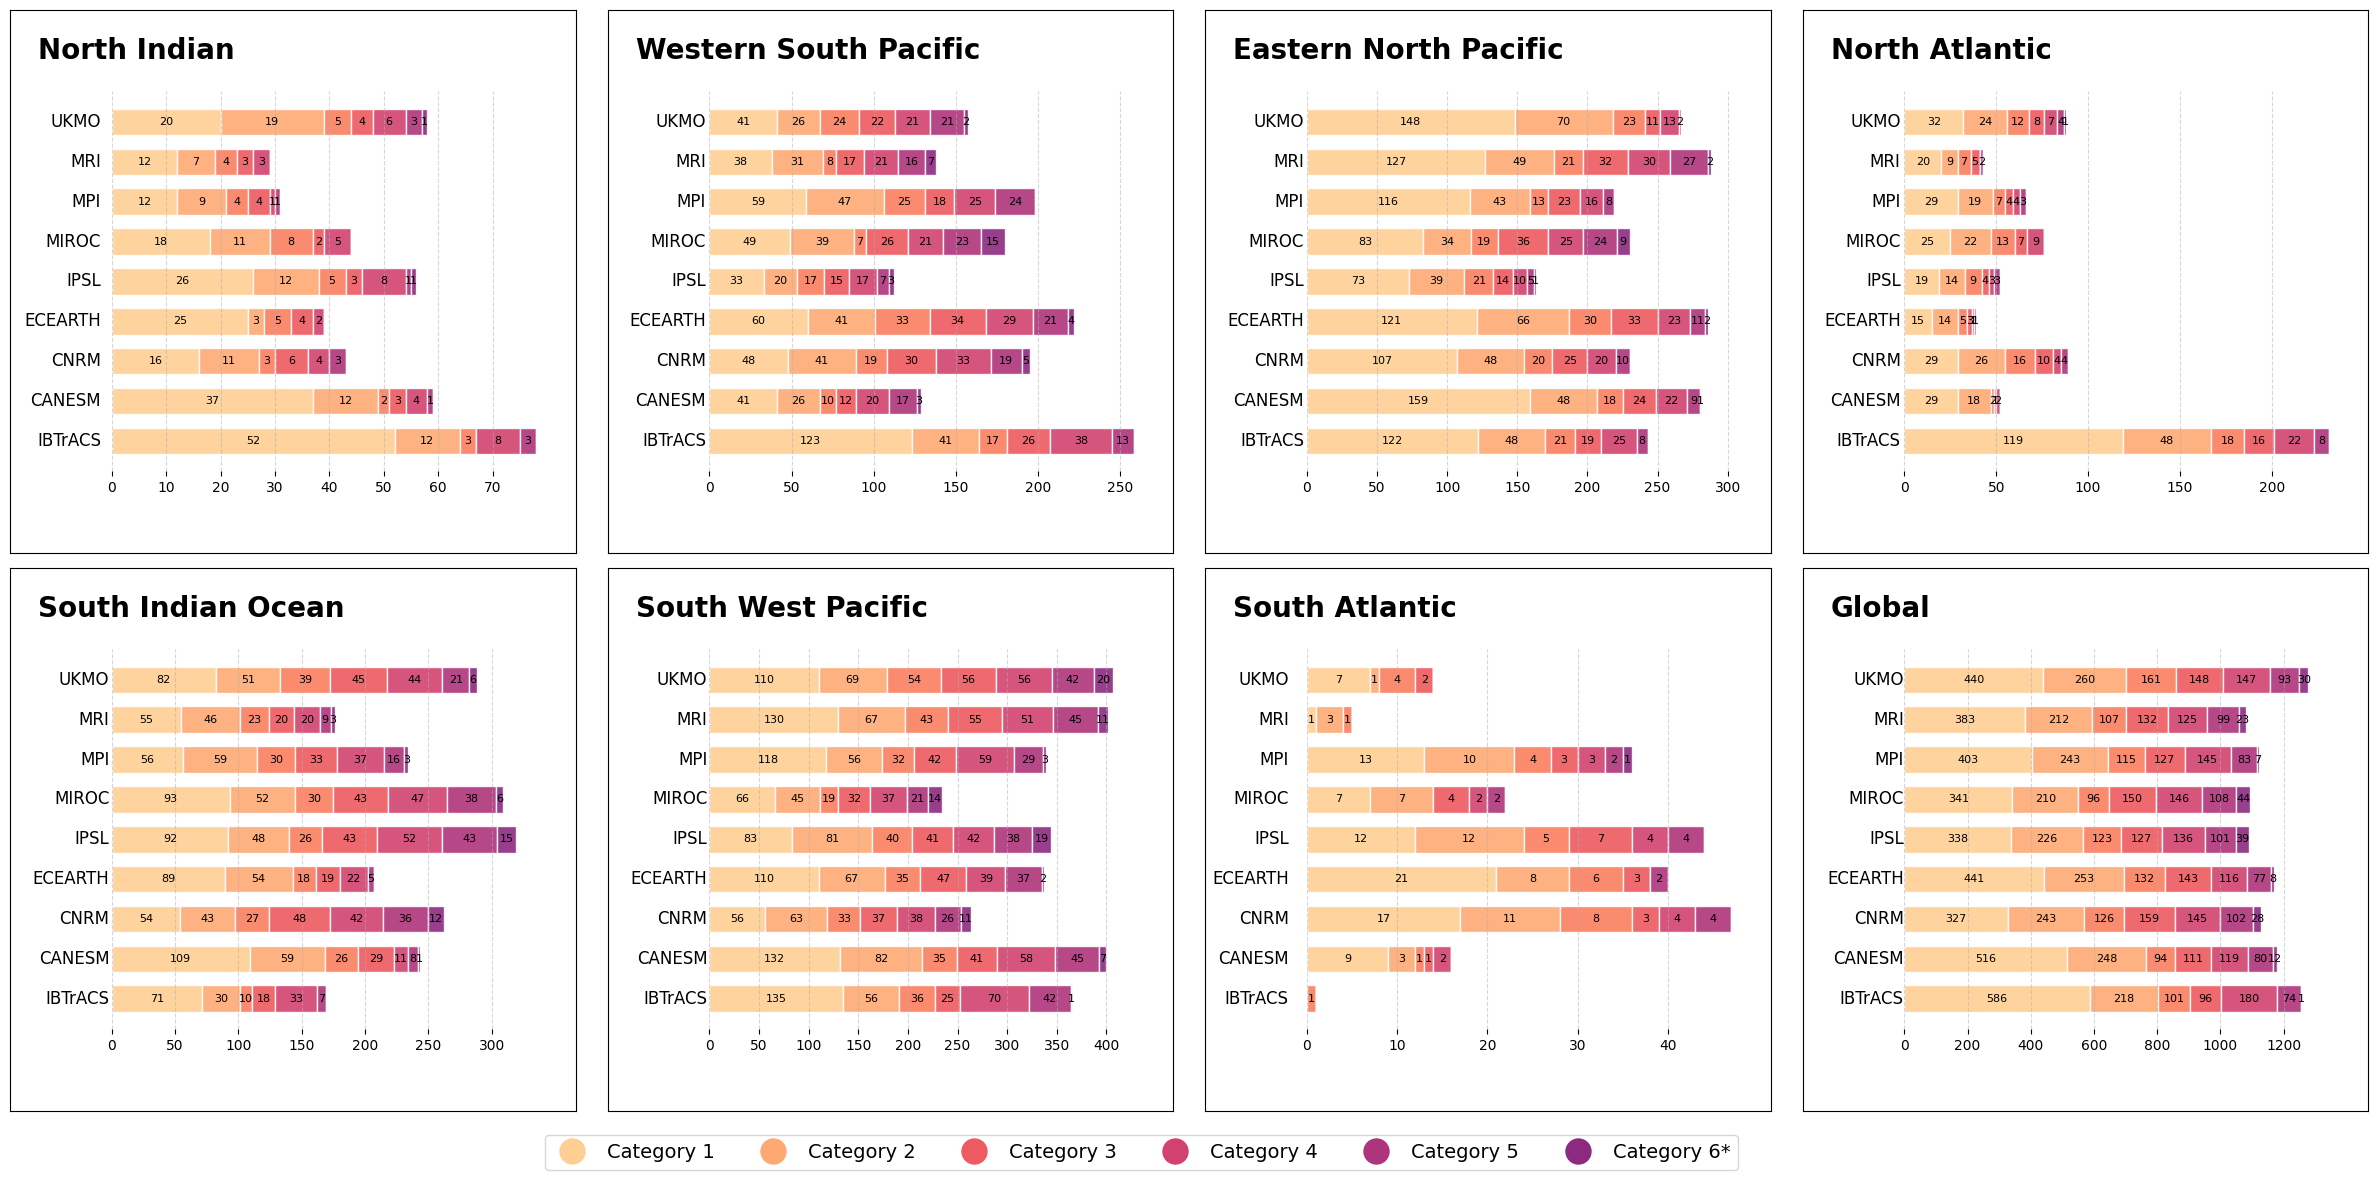

In [55]:
# Define the data for the stacked bar chart
num_categories = 7
num_bars = 9
data = np.random.randint(1, 10, size=(2, num_categories, num_bars))
basins = [ni,swp,nep,na,si,nwp,sa,glo]
models = ['ibtracs','canesm_hist','cnrm6_hist','ecearth6_hist','ipsl6_hist','miroc6_hist','mpi6_hist','mri6_hist','ukmo_hist']
model_names = ['IBTrACS','CANESM','CNRM','ECEARTH','IPSL','MIROC','MPI','MRI','UKMO']
cat = ['tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']

# Create subplots with 2 x 4 panels
fig, axs = plt.subplots(3, 4, figsize=(24, 12),sharex=True,gridspec_kw={'height_ratios': [1, 1,0.1]}) #20,10

# Define colors for the legend
legend_colors = plt.cm.magma_r(np.linspace(0.1, 0.6, num_categories))

# define panel titles
panel_titles = ['North Indian','Western South Pacific','Eastern North Pacific','North Atlantic','South Indian Ocean','South West Pacific','South Atlantic','Global']
l = 0

# Loop through each panel
for panel_num, ax_row in enumerate(axs):

    for i, ax in enumerate(ax_row):
        
        b = i
        if panel_num == 1:
            b = i + 4
        
        if panel_num == 2:
            continue
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        
        # Add inset axes for the bar chart
        inset_ax = ax.inset_axes([0.18, 0.15, 0.75, 0.7])

        # Remove inset axes spines
        inset_ax.spines['top'].set_visible(False)
        inset_ax.spines['right'].set_visible(False)
        inset_ax.spines['bottom'].set_visible(False)
        inset_ax.spines['left'].set_visible(False)

        # change x axis to log10?
        # inset_ax.set_xscale('log')

        # Add vertical grid lines
        inset_ax.grid(axis='x', linestyle='--', alpha=0.5)
        
        # Generate horizontal stacked bar chart for each panel
        bottom = np.zeros(num_bars)
        for j in range(num_categories):
            inset_ax.barh(np.arange(num_bars) * 1.2, basins[b][models].iloc[j+1], color=legend_colors[j], left=bottom, edgecolor='white',alpha=0.9)

            bottom += basins[b][models].iloc[j+1]
            
            
        # Remove inset axes ticks and labels
        inset_ax.yaxis.set_ticks([])
        
        # Add y-axis labels as text
        for k in range(num_bars):
            inset_ax.text(-2, k * 1.2, model_names[k], ha='right', va='center', fontsize=12)
        
        # Add text labels for each stack
        for j in range(num_categories):
            for k in range(num_bars):
                
                x_pos = np.sum(basins[b][models].drop(basins[b][models].index[0]).iloc[:j]).iloc[k] + 0.5 * basins[b][models].drop(basins[b][models].index[0]).iloc[j][k]
                if basins[b][models].iloc[j+1][k] == 0:
                    continue
                else:
                    inset_ax.text(x_pos, k * 1.2, basins[b][models].iloc[j+1][k], ha='center', va='center', color='black', fontsize=8)
        
        # inset_ax.set_xlim(100)
        # inset_ax.set_xticks([0,10,20,30,40,50,60,70,80,90])
        # inset_ax.set_xscale('log')
        # Add text in the top left corner of each panel
        ax.text(0.05, 0.95, panel_titles[l], transform=ax.transAxes, fontsize=20, verticalalignment='top',fontweight='bold')
        l = l + 1
        

# Create legend
legend_labels = [f'Category {i+1}' for i in range(num_categories)]
# ax.legend(legend_labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
# Define the colors and labels for the legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[0], markersize=20, label='Category 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[1], markersize=20, label='Category 2'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[3], markersize=20, label='Category 3'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[4], markersize=20, label='Category 4'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[5], markersize=20, label='Category 5'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[6], markersize=20, label='Category 6*')
]

# Create the legend and position it below the axes

# axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)
axs[2,3].set_visible(False)

axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)
axs[2,0].spines['bottom'].set_visible(False)
axs[2,0].spines['left'].set_visible(False)
axs[2,0].set_xticks([])
axs[2,0].set_yticks([])

# Adjust layout
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.95, wspace=0.4, hspace=0.2)

# Add inset axes for the bar chart
        # inset_ax = ax.inset_axes([0.2, 0.15, 0.75, 0.7])

# Adjust layout
plt.tight_layout()

axs[2,0].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(2, 1), fancybox=True, ncol=6,fontsize=14)

# Show plot
plt.savefig('cmip6_basin_count.png',bbox_inches='tight')

In [ ]:
ibtracs.gridded_stats(request="number of storms",prop={'cmap':'plasma_r'},thresh={'v_min':34.},year_range=(2000,2014))
plt.savefig('ibtracs_density_3.png',bbox_inches='tight',dpi=300)

In [ ]:
binsize = 1
def to_bin(x): return np.floor(x / binsize) * binsize
def calc_track_density(storm_data,lonshift=False,mask=True):
    binsize = 1
    latbin = storm_data.lat.map(to_bin)
    lonbin = storm_data.lon.map(to_bin)
    new_df = pd.DataFrame({'latbin': latbin, 'lonbin': lonbin, 'stormid':storm_data.sid})
    new_new_df = new_df.drop_duplicates()
    if lonshift == True:
        lat_bins = np.arange(-90, 91, 1)
        lon_bins = np.arange(-180, 181, 1)
    else:
        lat_bins = np.arange(-90, 91, 1)
        lon_bins = np.arange(0, 361, 1)
    density, _, _ = np.histogram2d(new_new_df.latbin, new_new_df.lonbin, bins=[lat_bins, lon_bins])
    masked_density = np.ma.masked_equal(density, 0)
    if mask == True:
        return masked_density
    else:
        return density
def mask(data):
    return np.ma.masked_equal(data, 0)


In [ ]:
(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)

In [ ]:
print(ukmo_tracks_ssp585)

In [ ]:
print(canesm_tracks_ssp585)

In [ ]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		if scenario == 'hist':
			yr1 = 2000
			yr2 = 2014
		else:
			yr1 = 2085
			yr2 = 2099
		data = globals()[f'{model}_tracks_{scenario}']
		wind_thresh = 34
		globals()[f'{model}_{scenario}_masked_density'] = calc_track_density(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= wind_thresh)])
	

In [ ]:
# # Compute histogram of cyclone tracks
# ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
# canesm_hist_masked_density = calc_track_density(canesm_tracks_hist[(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)])
# cnrm6_hist_masked_density = calc_track_density(cnrm6_tracks_hist[(cnrm6_tracks_hist.year >= 2000) & (cnrm6_tracks_hist.year <= 2014)])
# ecearth6_hist_masked_density = calc_track_density(ecearth6_tracks_hist[(ecearth6_tracks_hist.year >= 2000) & (ecearth6_tracks_hist.year <= 2014)])
# ipsl6_hist_masked_density = calc_track_density(ipsl6_tracks_hist[(ipsl6_tracks_hist.year >= 2000) & (ipsl6_tracks_hist.year <= 2014)])
# miroc6_hist_masked_density = calc_track_density(miroc6_tracks_hist[(miroc6_tracks_hist.year >= 2000) & (miroc6_tracks_hist.year <= 2014)])
# mpi6_hist_masked_density = calc_track_density(mpi6_tracks_hist[(mpi6_tracks_hist.year >= 2000) & (mpi6_tracks_hist.year <= 2014)])
# mri6_hist_masked_density = calc_track_density(mri6_tracks_hist[(mri6_tracks_hist.year >= 2000) & (mri6_tracks_hist.year <= 2014)])
# ukmo_hist_masked_density = calc_track_density(ukmo_tracks_hist[(ukmo_tracks_hist.year >= 2000) & (ukmo_tracks_hist.year <= 2014)])



In [ ]:
# canesm_ssp585_masked_density = calc_track_density(canesm_tracks_ssp585[(canesm_tracks_ssp585.year >= 2085) & (canesm_tracks_ssp585.year <= 2099)])
# cnrm6_ssp585_masked_density = calc_track_density(cnrm6_tracks_ssp585[(cnrm6_tracks_ssp585.year >= 2085) & (cnrm6_tracks_ssp585.year <= 2099)])
# ecearth6_ssp585_masked_density = calc_track_density(ecearth6_tracks_ssp585[(ecearth6_tracks_ssp585.year >= 2085) & (ecearth6_tracks_ssp585.year <= 2099)])
# ipsl6_ssp585_masked_density = calc_track_density(ipsl6_tracks_ssp585[(ipsl6_tracks_ssp585.year >= 2085) & (ipsl6_tracks_ssp585.year <= 2099)])
# miroc6_ssp585_masked_density = calc_track_density(miroc6_tracks_ssp585[(miroc6_tracks_ssp585.year >= 2085) & (miroc6_tracks_ssp585.year <= 2099)])
# mpi6_ssp585_masked_density = calc_track_density(mpi6_tracks_ssp585[(mpi6_tracks_ssp585.year >= 2085) & (mpi6_tracks_ssp585.year <= 2099)])
# mri6_ssp585_masked_density = calc_track_density(mri6_tracks_ssp585[(mri6_tracks_ssp585.year >= 2085) & (mri6_tracks_ssp585.year <= 2099)])
# ukmo_ssp585_masked_density = calc_track_density(ukmo_tracks_ssp585[(ukmo_tracks_ssp585.year >= 2085) & (ukmo_tracks_ssp585.year <= 2099)])


In [ ]:
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_NH.csv')
indices = (mswep_sids['year'] >= 2000) & (mswep_sids['year'] <= 2014)
mswep_sids = mswep_sids[indices].reset_index()
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'lat':mswep_sids.centre_lat, 'lon':mswep_sids.centre_lon, 'hour':mswep_sids.hour, 'year':mswep_sids.year})


In [ ]:
mswep_sids

In [ ]:

ibtracs_masked_density = calc_track_density(meta_mswep,lonshift=True)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
im = ax.pcolor(np.arange(-180,180),np.arange(-90,90),ibtracs_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=35)
ax.add_feature(cfeature.COASTLINE,linewidth=0.5) 
ax.set_global()
plt.colorbar(im,ticks=range(0,35,5),ax=ax)
plt.savefig('ibtrack_density.png',bbox_inches='tight',dpi=300)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmax = 28
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),canesm_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),cnrm6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),ecearth6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),ipsl6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),miroc6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mpi6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mri6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),ukmo_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)
    ax.set_global()


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density2.png',bbox_inches='tight',dpi=300)


In [ ]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		if scenario == 'hist':
			yr1 = 2000
			yr2 = 2014
		else:
			yr1 = 2085
			yr2 = 2099
		data = globals()[f'{model}_tracks_{scenario}']
		wind_thresh = 34
		globals()[f'{model}_{scenario}_masked_density'] = calc_track_density(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= wind_thresh)],mask=False)


In [ ]:
# # Compute histogram of cyclone tracks
# ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
# canesm_hist_masked_density = calc_track_density(canesm_tracks_hist[(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)],mask=False)
# cnrm6_hist_masked_density = calc_track_density(cnrm6_tracks_hist[(cnrm6_tracks_hist.year >= 2000) & (cnrm6_tracks_hist.year <= 2014)],mask=False)
# ecearth6_hist_masked_density = calc_track_density(ecearth6_tracks_hist[(ecearth6_tracks_hist.year >= 2000) & (ecearth6_tracks_hist.year <= 2014)],mask=False)
# ipsl6_hist_masked_density = calc_track_density(ipsl6_tracks_hist[(ipsl6_tracks_hist.year >= 2000) & (ipsl6_tracks_hist.year <= 2014)],mask=False)
# miroc6_hist_masked_density = calc_track_density(miroc6_tracks_hist[(miroc6_tracks_hist.year >= 2000) & (miroc6_tracks_hist.year <= 2014)],mask=False)
# mpi6_hist_masked_density = calc_track_density(mpi6_tracks_hist[(mpi6_tracks_hist.year >= 2000) & (mpi6_tracks_hist.year <= 2014)],mask=False)
# mri6_hist_masked_density = calc_track_density(mri6_tracks_hist[(mri6_tracks_hist.year >= 2000) & (mri6_tracks_hist.year <= 2014)],mask=False)
# ukmo_hist_masked_density = calc_track_density(ukmo_tracks_hist[(ukmo_tracks_hist.year >= 2000) & (ukmo_tracks_hist.year <= 2014)],mask=False)

# canesm_ssp585_masked_density = calc_track_density(canesm_tracks_ssp585[(canesm_tracks_ssp585.year >= 2085) & (canesm_tracks_ssp585.year <= 2099)],mask=False)
# cnrm6_ssp585_masked_density = calc_track_density(cnrm6_tracks_ssp585[(cnrm6_tracks_ssp585.year >= 2085) & (cnrm6_tracks_ssp585.year <= 2099)],mask=False)
# ecearth6_ssp585_masked_density = calc_track_density(ecearth6_tracks_ssp585[(ecearth6_tracks_ssp585.year >= 2085) & (ecearth6_tracks_ssp585.year <= 2099)],mask=False)
# ipsl6_ssp585_masked_density = calc_track_density(ipsl6_tracks_ssp585[(ipsl6_tracks_ssp585.year >= 2085) & (ipsl6_tracks_ssp585.year <= 2099)],mask=False)
# miroc6_ssp585_masked_density = calc_track_density(miroc6_tracks_ssp585[(miroc6_tracks_ssp585.year >= 2085) & (miroc6_tracks_ssp585.year <= 2099)],mask=False)
# mpi6_ssp585_masked_density = calc_track_density(mpi6_tracks_ssp585[(mpi6_tracks_ssp585.year >= 2085) & (mpi6_tracks_ssp585.year <= 2099)],mask=False)
# mri6_ssp585_masked_density = calc_track_density(mri6_tracks_ssp585[(mri6_tracks_ssp585.year >= 2085) & (mri6_tracks_ssp585.year <= 2099)],mask=False)
# ukmo_ssp585_masked_density = calc_track_density(ukmo_tracks_ssp585[(ukmo_tracks_ssp585.year >= 2085) & (ukmo_tracks_ssp585.year <= 2099)],mask=False)


In [ ]:
print(mpi6_tracks_ssp585)

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmin=-10
vmax = 10 
cmap = 'RdBu_r'
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(canesm_ssp585_masked_density - canesm_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(cnrm6_ssp585_masked_density - cnrm6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(ecearth6_ssp585_masked_density - ecearth6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ipsl6_ssp585_masked_density - ipsl6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(miroc6_ssp585_masked_density - miroc6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(mpi6_ssp585_masked_density - mpi6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(mri6_ssp585_masked_density - mri6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ukmo_ssp585_masked_density - ukmo_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)
    ax.set_global()


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density_anomaly2.png',bbox_inches='tight',dpi=300)


In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmax = 35 
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(canesm_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(cnrm6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(ecearth6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ipsl6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(miroc6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(mpi6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(mri6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ukmo_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)
    ax.set_global()


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density_ssp585_2.png',bbox_inches='tight',dpi=300)


In [ ]:
plt.imshow(ukmo_ssp585_masked_density)

In [ ]:
# for i,l in enumerate(canesm_tracks_hist.lon):
#     if l > 180:
#         canesm_tracks_hist.lon[i] = l - 360

# sids = canesm_tracks_hist.sid
# sids_unique=sids.drop_duplicates()
# tracks_grouped = canesm_tracks_hist.groupby('sid')


# for sid in sids_unique:
#     storm = tracks_grouped.get_group(sid)

In [ ]:
for i in range(6):
    # row, col = divmod(i, 3)
    print(titles[i])
    data_ssp585 = np.concatenate((canesm_tracks_ssp585[:,i],cnrm6_tracks_ssp585[:,i],ecearth6_tracks_ssp585[:,i],miroc6_tracks_ssp585[:,i],mpi6_tracks_ssp585[:,i]))
    data_ssp245 = np.concatenate((canesm_tracks_ssp245[:,i],cnrm6_tracks_ssp245[:,i],ecearth6_tracks_ssp245[:,i],miroc6_tracks_ssp245[:,i],mpi6_tracks_ssp245[:,i]))
    data_hist = np.concatenate((canesm_tracks_hist[:,i],cnrm6_tracks_hist[:,i],ecearth6_tracks_hist[:,i],miroc6_tracks_hist[:,i],mpi6_tracks_hist[:,i]))
    

    # 1. Kolmogorov-Smirnov Test
    ks_statistic, ks_p_value = stats.ks_2samp(data_hist, data_ssp245)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")
    ks_statistic, ks_p_value = stats.ks_2samp(data_hist, data_ssp585)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")
    ks_statistic, ks_p_value = stats.ks_2samp(data_ssp585, data_ssp245)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")

    # 2. Anderson-Darling Test
    ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson_ksamp([data_hist, data_ssp245,data_ssp585])
    print(f"Anderson-Darling Test: Statistic = {ad_statistic}")

    # 3. Cramér-von Mises Test
    # cvm_statistic, cvm_p_value = stats.cramervonmises(data1, data2)
    # print(f"Cramér-von Mises Test: Statistic = {cvm_statistic}, p-value = {cvm_p_value}")


In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(canesm_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(cnrm6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(ecearth6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(ipsl6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(miroc6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(mpi6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(tracks_ssp245[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    # if i == 0:
    #     tracks_hist[:,i] = tracks_hist[:,i] * 100
    #     tracks_ssp245[:,i] = tracks_ssp245[:,i] * 100
    #     tracks_585[:,i] = tracks_585[:,i] * 100
    # sns.kdeplot(tracks_585[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_11a_inputs.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(canesm_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(cnrm6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(ecearth6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(ipsl6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(miroc6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(mpi6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(tracks_ssp245[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    # if i == 0:
    #     tracks_hist[:,i] = tracks_hist[:,i] * 100
    #     tracks_ssp245[:,i] = tracks_ssp245[:,i] * 100
    #     tracks_585[:,i] = tracks_585[:,i] * 100
    # sns.kdeplot(tracks_585[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_11a_inputs.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
# plot topography
from mpl_toolkits.mplot3d import Axes3D
print(cnrm_topography_hist.shape)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate data for the surface
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z_land = topography_hist[495,:,:]
z_ocean = topography_hist[0,:,:]

# Plot the surface
surface = ax.plot_surface(x, y, z_land, cmap='terrain',linewidth=0, antialiased=False, alpha=0.7)
# surface = ax.plot_surface(x, y, z_ocean, cmap='ocean',linewidth=0, antialiased=False, alpha=0.7)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))

# Customize the viewing angle
# ax.view_init(elev=25, azim=-35)
ax.view_init(elev=34, azim=60)

# Remove background
# Remove background and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.set_axis_off()

# Add a color bar which maps values to colors
cbar = fig.colorbar(surface, shrink=0.5, aspect=20,pad=-0.82)
cbar.set_label('Elevation (m)', labelpad=-70)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(axis='both', which='both', width=0.5,labelsize=8)

# Show the plot

plt.savefig('figure_11b_topography.png',bbox_inches='tight',dpi=600)

In [ ]:
print(tracks_hist[495,:])

In [ ]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.Robinson()})

# ax.set_xlim([-180, 180])
# ax.set_ylim([-90, 90])

ax.scatter(p_10[:,5],p_10[:,4], color="#A8CCE3",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_20[:,5],p_20[:,4], color="#98B5D9",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_30[:,5],p_30[:,4], color="#89A0CF",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_40[:,5],p_40[:,4], color="#799AC5",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_50[:,5],p_50[:,4], color="#6A88BB",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_60[:,5],p_60[:,4], color="#5B78B0",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_70[:,5],p_70[:,4], color="#4C67A6",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_80[:,5],p_80[:,4], color="#3E579C",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_90[:,5],p_90[:,4], color="#2F4792",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_100[:,5],p_100[:,4], color="#204587",s=1,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('Storm distribution',fontsize=14,pad=15)
ax.set_global()
plt.savefig('figure_9c_storm_distribution_4.png')